In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.compose import ColumnTransformer

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
df= pd.read_csv("/content/drive/MyDrive/Final Assessment 2/smoking_health_data_final.csv")
df.head()


,age,sex,current_smoker,heart_rate,blood_pressure,cigs_per_day,chol
0,54,male,yes,95,110/72,NaN,219.0
1,45,male,yes,64,121/72,NaN,248.0
2,58,male,yes,81,127.5/76,NaN,235.0
3,42,male,yes,90,122.5/80,NaN,225.0
4,42,male,yes,62,119/80,NaN,226.0


In [21]:
# Dataset description
print("\nDataset Information:")
print(df.info())

# Summary statistics
print("\nSummary Statistics:")
print(df.describe())

# List of attributes (columns)
columns = df.columns.tolist()
print("\nList of Attributes (Columns):")
print(columns)


Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             3900 non-null   int64  
 1   sex             3900 non-null   object 
 2   current_smoker  3900 non-null   object 
 3   heart_rate      3900 non-null   int64  
 4   blood_pressure  3900 non-null   object 
 5   cigs_per_day    3886 non-null   float64
 6   chol            3893 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 213.4+ KB
None

Summary Statistics:
               age   heart_rate  cigs_per_day         chol
count  3900.000000  3900.000000   3886.000000  3893.000000
mean     49.537949    75.688974      9.168554   236.595941
std       8.559275    12.015376     12.037999    44.375365
min      32.000000    44.000000      0.000000   113.000000
25%      42.000000    68.000000      0.000000   206.000000
50%      49.000000    7

In [22]:
if 'sex' in df.columns:

  df['sex'] = df['sex'].map({'male': 1, 'female': 0})
if 'current_smoker' in df.columns:
  df['current_smoker'] = df['current_smoker'].map({'yes': 1, 'no': 0})

if 'blood_pressure' in df.columns:
    df[['systolic_bp', 'diastolic_bp']] = df['blood_pressure'].str.split('/', expand=True).astype(float)
    df.drop(columns=['blood_pressure'], inplace=True)

else:
    print("Column 'blood_pressure' not found in the dataset!")


# Drop the original blood_pressure column
if 'blood_pressure' in df.columns:
  df.drop(columns=['blood_pressure'], inplace=True)

# Fill missing values with median for numeric columns
df.fillna(df.median(), inplace=True)
print(df.head())
print(df.info())
df = df.drop(columns=["Order_ID"], errors='ignore')
print("\nMissing Values:")
print(df.isnull().sum())

   age  sex  current_smoker  heart_rate  cigs_per_day   chol  systolic_bp  \
0   54    1               1          95           0.0  219.0        110.0   
1   45    1               1          64           0.0  248.0        121.0   
2   58    1               1          81           0.0  235.0        127.5   
3   42    1               1          90           0.0  225.0        122.5   
4   42    1               1          62           0.0  226.0        119.0   

   diastolic_bp  
0          72.0  
1          72.0  
2          76.0  
3          80.0  
4          80.0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             3900 non-null   int64  
 1   sex             3900 non-null   int64  
 2   current_smoker  3900 non-null   int64  
 3   heart_rate      3900 non-null   int64  
 4   cigs_per_day    3900 non-null   float64
 5   cho

#Exploring data through visualization


###Age Distribution

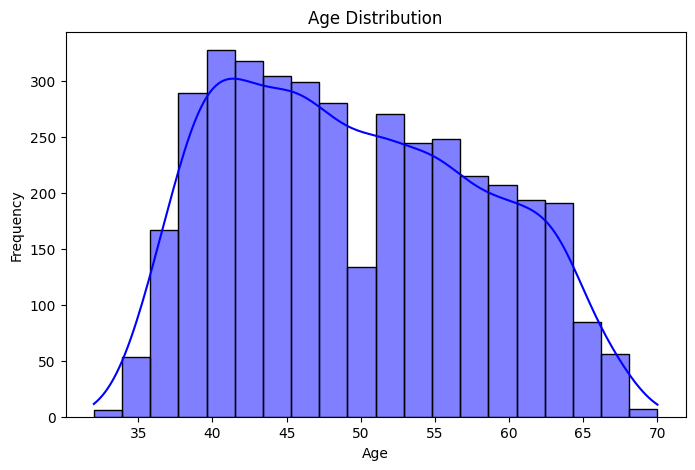

In [40]:
plt.figure(figsize=(8, 5))
sns.histplot(df['age'], bins=20, kde=True, color='blue')
plt.title("Age Distribution")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.show()


###Smoking Status Count

<ipython-input-41-59c5a9a883af>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df['current_smoker'], palette="coolwarm")


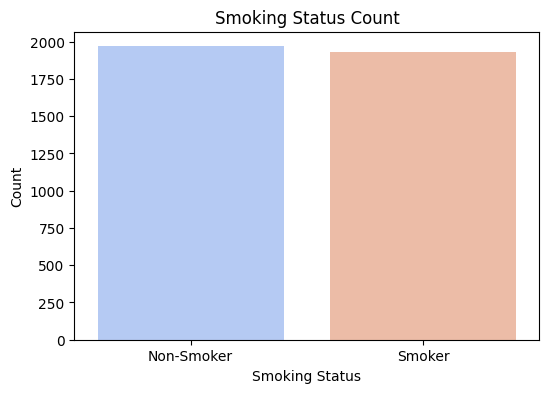

In [41]:
plt.figure(figsize=(6, 4))
sns.countplot(x=df['current_smoker'], palette="coolwarm")
plt.xticks([0, 1], ['Non-Smoker', 'Smoker'])
plt.title("Smoking Status Count")
plt.xlabel("Smoking Status")
plt.ylabel("Count")
plt.show()


###Cholesterol Levels by Smoking Status




<ipython-input-42-885979ba13d7>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df['current_smoker'], y=df['chol'], palette="Set2")


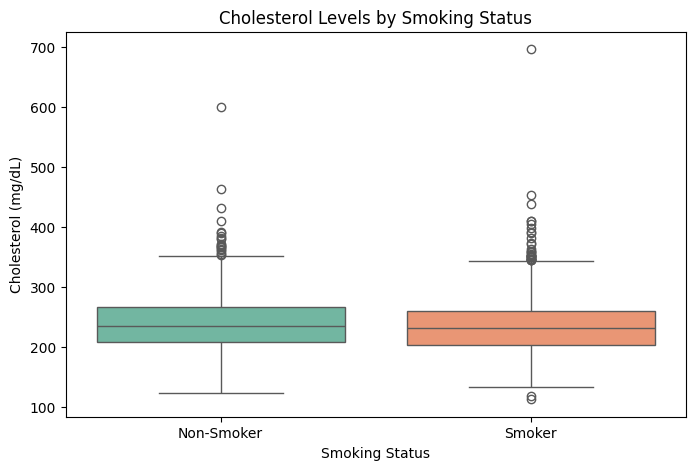

In [42]:
plt.figure(figsize=(8, 5))
sns.boxplot(x=df['current_smoker'], y=df['chol'], palette="Set2")
plt.xticks([0, 1], ['Non-Smoker', 'Smoker'])
plt.title("Cholesterol Levels by Smoking Status")
plt.xlabel("Smoking Status")
plt.ylabel("Cholesterol (mg/dL)")
plt.show()


In [24]:
def cost_function(X, Y, W):
    """ Parameters:
    This function finds the Mean Square Error.
    Input parameters:
      X: Feature Matrix
      Y: Target Matrix
      W: Weight Matrix
    Output Parameters:
      J: accumulated mean square error.
    """
    # Your code here:
    m= len(Y)

    J= np.sum((X.dot(W) - Y)**2)/(2*m)
    return J

In [25]:

def gradient_descent(X, Y, B, alpha, iterations):
    cost_history = [0] * iterations
    m = len(Y)

    for iteration in range(iterations):
        # Hypothesis Values
        Y_pred = X.dot(W)
        # Difference b/w Hypothesis and Actual Y
        loss = Y-Y_pred
        # Gradient Calculation
        dw = - X.T.dot(loss)/m
        # Changing Values of B using Gradient
        W_update = W - alpha *dw
        # New Cost Value
        cost = cost_function(X, Y, W_update)
        cost_history[iteration] = cost

    return W_update, cost_history

In [27]:

x = df.drop(columns=['chol'])
# Define the target variable
y = df['chol']

# Split the dataset into 80% training data and 20% testing data
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initialize weights
W = np.zeros(X_train.shape[1])

alpha = 0.01
# Train the model using gradient descent
new_weights, cost_history = gradient_descent(X_train, Y_train, W, alpha, 1000)
print(new_weights)
print(cost_history[-1])

# Make predictions on the test set
Y_pred = X_test.dot(new_weights)

inital_cost = cost_function(x, y, W)
print(inital_cost)

[ 0.10902595 -0.02941054 -0.01801102  0.04192838 -0.01153247  0.09311832
  0.0685509 ]
28947.00877352835
28970.290256410255


In [28]:
mse = mean_squared_error(Y_test, Y_pred)
print(f"Mean Squared Error: {mse}")
rse= np.sqrt(mse)
print(f"Root Mean Squared Error: {rse}")
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")


Mean Squared Error: 58092.154745869724
Root Mean Squared Error: 241.02314151522822
Root Mean Squared Error (RMSE): 241.02314151522822


In [30]:
from sklearn.linear_model import LinearRegression

X = df.drop(columns=['chol'])
y = df['chol']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [31]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, r2_score

# Example: Assume X_train, X_test, y_train, y_test are your datasets
degree = 2  # You can change the degree to test different polynomial levels
model = make_pipeline(PolynomialFeatures(degree), LinearRegression())

# Train the model
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Calculate MSE and R²
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R-squared Score (R²): {r2:.4f}")


Mean Squared Error (MSE): 1564.8889
R-squared Score (R²): 0.1679


In [32]:
dt_reg = DecisionTreeRegressor(random_state=42)
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)

# Training models
dt_reg.fit(X_train, y_train)
rf_reg.fit(X_train, y_train)

# Making predictions
y_pred_dt = dt_reg.predict(X_test)
y_pred_rf = rf_reg.predict(X_test)

# Evaluating models
def evaluate_model(y_true, y_pred, model_name):
    print(f"{model_name} Performance:")
    print(f"Mean Squared Error: {mean_squared_error(y_true, y_pred):.4f}")
    print(f"Mean Absolute Error: {mean_absolute_error(y_true, y_pred):.4f}")
    print(f"R-squared Score: {r2_score(y_true, y_pred):.4f}\n")

evaluate_model(y_test, y_pred_dt, "Decision Tree Regression")
evaluate_model(y_test, y_pred_rf, "Random Forest")

Decision Tree Regression Performance:
Mean Squared Error: 3371.9769
Mean Absolute Error: 45.9590
R-squared Score: -0.7930

Random Forest Performance:
Mean Squared Error: 1667.6850
Mean Absolute Error: 32.1272
R-squared Score: 0.1133



In [33]:
from sklearn.model_selection import GridSearchCV

param_grid_rf = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}
grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid_rf, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)

print("Best Hyperparameters for Random Forest:")
print(grid_search.best_params_)
print(f"Best R2 Score: {grid_search.best_score_:.4f}")

Best Hyperparameters for Random Forest:
{'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 150}
Best R2 Score: 0.0788


In [34]:
param_grid_dt = {
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search_dt = GridSearchCV(DecisionTreeRegressor(random_state=42), param_grid_dt, cv=5, scoring='r2')
grid_search_dt.fit(X_train, y_train)

print("Best Hyperparameters for Decision Tree Regressor:")
print(grid_search_dt.best_params_)
print(f"Best R2 Score: {grid_search_dt.best_score_:.4f}")

Best Hyperparameters for Decision Tree Regressor:
{'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10}
Best R2 Score: -0.1568


In [35]:
from sklearn.feature_selection import SelectFromModel

# Initialize models
rf_model = RandomForestRegressor()
dt_model = DecisionTreeRegressor()

# Fit Random Forest Regressor
rf_model.fit(X_train, y_train)
# Fit Decision Tree Regressor
dt_model.fit(X_train, y_train)

# SelectFromModel for Random Forest
rf_selector = SelectFromModel(rf_model, threshold="mean", max_features=6)
X_selected_rf = rf_selector.transform(X_train)

# SelectFromModel for Decision Tree
dt_selector = SelectFromModel(dt_model, threshold="mean", max_features=6)
X_selected_dt = dt_selector.transform(X_train)

print("Selected features from Random Forest (indices):", rf_selector.get_support())
print("Selected features from Decision Tree (indices):", dt_selector.get_support())

# Get the selected feature names
selected_rf_features = x.columns[rf_selector.get_support()]
selected_dt_features = x.columns[dt_selector.get_support()]

print("Selected features from Random Forest:", selected_rf_features)
print("Selected features from Decision Tree:", selected_dt_features)

Selected features from Random Forest (indices): [ True False False  True False  True  True]
Selected features from Decision Tree (indices): [ True False False  True False  True  True]
Selected features from Random Forest: Index(['age', 'heart_rate', 'systolic_bp', 'diastolic_bp'], dtype='object')
Selected features from Decision Tree: Index(['age', 'heart_rate', 'systolic_bp', 'diastolic_bp'], dtype='object')


<ipython-input-36-f85f5870b513>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=rf_importance_df, palette='Blues_d')


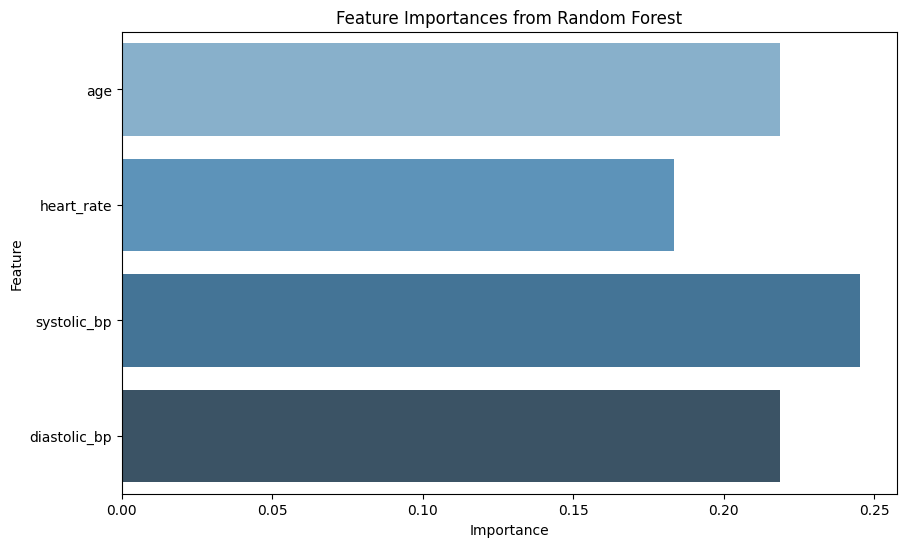

<ipython-input-36-f85f5870b513>:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=dt_importance_df, palette='Greens_d')


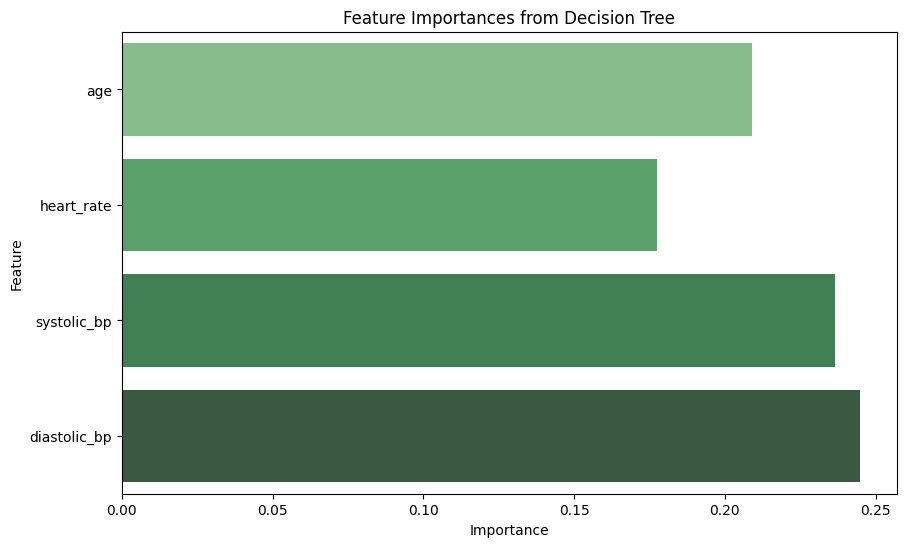

In [36]:
# Get feature importances
rf_importances = rf_model.feature_importances_
dt_importances = dt_model.feature_importances_

# Get the names of the selected features
selected_rf_features = X.columns[rf_selector.get_support()]
selected_dt_features = X.columns[dt_selector.get_support()]

# Extract the importance of the selected features
rf_selected_importances = rf_importances[rf_selector.get_support()]
dt_selected_importances = dt_importances[dt_selector.get_support()]
rf_importance_df = pd.DataFrame({
    'Feature': selected_rf_features,
    'Importance': rf_selected_importances
})

dt_importance_df = pd.DataFrame({
    'Feature': selected_dt_features,
    'Importance': dt_selected_importances
})

# Plot the feature importances for Random Forest
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=rf_importance_df, palette='Blues_d')
plt.title('Feature Importances from Random Forest')
plt.show()

# Plot the feature importances for Decision Tree
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=dt_importance_df, palette='Greens_d')
plt.title('Feature Importances from Decision Tree')
plt.show()


Random Forest Regressor Evaluation:
Mean Absolute Error: 32.6168
Mean Squared Error: 1712.6216
R^2 Score: 0.0894


<ipython-input-39-1cc0d79a0258>:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='Blues_d')


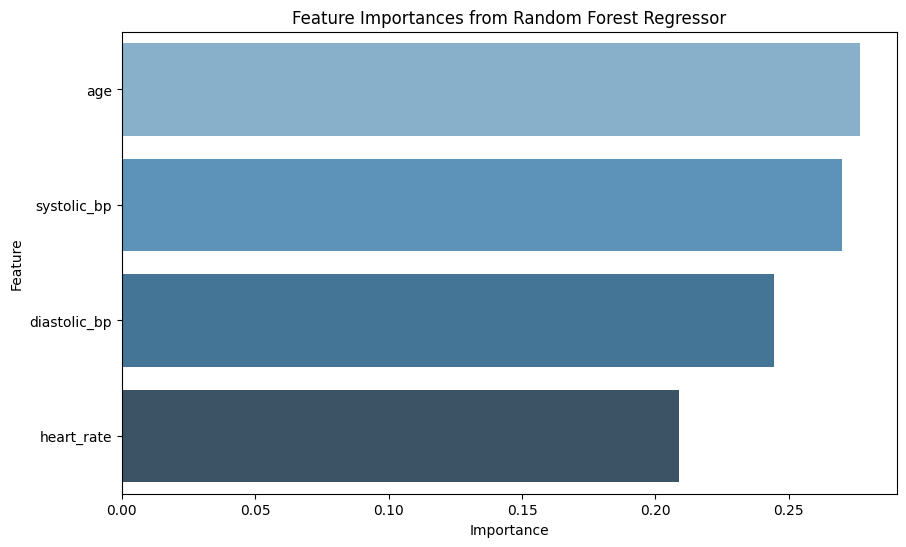

In [39]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming x_train_scaled_df and x_test_scaled_df are DataFrames with scaled features
x_train_scaled_df = pd.DataFrame(X_train, columns=X.columns)
x_test_scaled_df = pd.DataFrame(X_test, columns=X.columns)
# Select the important features from Task 5
selected_features_rf = ['age', 'heart_rate','systolic_bp','diastolic_bp']

# Subset the dataset with selected features
x_train_rf = x_train_scaled_df[selected_features_rf]
x_test_rf = x_test_scaled_df[selected_features_rf]

# Rebuild Random Forest Regressor model with optimal hyperparameters
rf_regressor = RandomForestRegressor(n_estimators=150, max_depth=10, min_samples_split=2, random_state=42)
rf_regressor.fit(x_train_rf, y_train)

# Predict with the trained model
y_pred_rf = rf_regressor.predict(x_test_rf)

# Evaluate Random Forest Regressor
mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("\nRandom Forest Regressor Evaluation:")
print(f"Mean Absolute Error: {mae_rf:.4f}")
print(f"Mean Squared Error: {mse_rf:.4f}")
print(f"R^2 Score: {r2_rf:.4f}")

# Feature Importance Plot
feature_importances = rf_regressor.feature_importances_
importance_df = pd.DataFrame({
    'Feature': selected_features_rf,
    'Importance': feature_importances
})

# Sort by feature importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='Blues_d')
plt.title('Feature Importances from Random Forest Regressor')
plt.show()


